# 05_TF-IDF
## Ray Hossain

### Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.sparse as sp

In [2]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rafid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Long Format Data

In [3]:
df = pd.read_csv("Processed_Data/30_merged_long.csv")

In [4]:
df.head()

,personid,urlid,duration,text_clean,secondvote,vote_left,vote_green,vote_spd,vote_na_other,vote_fdp,...,ml_degreestatus,ml_political_interest,adjustedvote,polinterest,adjustedincome,fgender,fvoceduc,frelationship,fmaritalstatus,femployment
0,1120454,ger-24,117.0,inland volker kauder rechnet verfassungsklage ...,3,0,0,0,0,1,...,0,1,1,5,5,männlich,Lehre oder vergleichbarer Abschluss,"In einer Beziehung, mit Partner/in zusammenlebend",geschieden,Erwerbst?tigkeit/Berufst?tigkeit
1,1120454,ger-24,21.0,inland volker kauder rechnet verfassungsklage ...,3,0,0,0,0,1,...,0,1,1,5,5,männlich,Lehre oder vergleichbarer Abschluss,"In einer Beziehung, mit Partner/in zusammenlebend",geschieden,Erwerbst?tigkeit/Berufst?tigkeit
2,1120454,ger-302,62.0,07-01 wer wei denn sowas xxl stream quiz kai p...,3,0,0,0,0,1,...,0,1,1,5,5,männlich,Lehre oder vergleichbarer Abschluss,"In einer Beziehung, mit Partner/in zusammenlebend",geschieden,Erwerbst?tigkeit/Berufst?tigkeit
3,1120454,ger-302,32.0,07-01 wer wei denn sowas xxl stream quiz kai p...,3,0,0,0,0,1,...,0,1,1,5,5,männlich,Lehre oder vergleichbarer Abschluss,"In einer Beziehung, mit Partner/in zusammenlebend",geschieden,Erwerbst?tigkeit/Berufst?tigkeit
4,1120454,ger-302,10.0,07-01 wer wei denn sowas xxl stream quiz kai p...,3,0,0,0,0,1,...,0,1,1,5,5,männlich,Lehre oder vergleichbarer Abschluss,"In einer Beziehung, mit Partner/in zusammenlebend",geschieden,Erwerbst?tigkeit/Berufst?tigkeit


### Stopwords & Additional Processing

In [5]:
# Get German stopwords from NLTK
german_stopwords = stopwords.words('german')

# Replace NaN values with an empty string
df['text_clean'] = df['text_clean'].fillna('')


### TF-IDF

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create a TF-IDF vectorizer with German-specific settings
tfidf_vectorizer = TfidfVectorizer(
    min_df=5,
    max_df=0.8,
    stop_words=german_stopwords
)

# Transform your text data
features = tfidf_vectorizer.fit_transform(df['text_clean'])

In [7]:
print(features.shape)
# (number of rows, number of tokens)

(452855, 34548)


## Aggregation

### Calculating the mean of TF-DF scores for each article

In [8]:
# Calculate the mean TF-IDF value for each document (row)
mean_tfidf = features.mean(axis=1)

# Convert the sparse matrix result to a regular array
mean_tfidf_array = mean_tfidf.A.flatten()

# Add this as a new column to your dataframe
df['tf_idf_mean'] = mean_tfidf_array

In [9]:
df[['personid', 'tf_idf_mean']]

,personid,tf_idf_mean
0,1120454,0.000070
1,1120454,0.000070
2,1120454,0.000101
3,1120454,0.000101
4,1120454,0.000101
...,...,...
452850,41378722,0.000000
452851,41571157,0.000000
452852,41791374,0.000000
452853,41942929,0.000000


### Additional Aggregation of TD-IDF Scores

**Entity-weighted scoring**: For capturing entities & specialized terms

- Identifies named entities in your German text (people, places, organizations, etc.)
- Gives twice the weight to TF-IDF scores for terms that are part of named entities

**Syntactic-weighted scoring**: For capturing actors and actions; focuses on linguistics

- Analyzes the grammatical structure of German sentences
- Assigns higher weights to subjects, objects, and main verbs
- Also considers part-of-speech, giving more weight to nouns, verbs, and proper nouns

In [10]:
import numpy as np
import re
from scipy.sparse import csr_matrix

# A list of German nouns and important words endings
# These are often indicators of nouns in German
important_word_endings = [
    "ung", "heit", "keit", "schaft", "tum", "nis", "mus", "er", "ler", "ner", 
    "or", "ist", "eur", "tät", "ion", "ik", "um", "ium", "ian", "us", "a", "e", "o"
]

def is_likely_entity(word, stopwords_list):
    """
    Simple heuristic to identify potential named entities in German
    """
    # For preprocessed text that's already lowercase, we can only use other heuristics
    word = re.sub(r'[^\w\s]', '', word)
    
    # Since your text is already lowercase, we'll use length and non-stopword status
    return word and len(word) > 5 and word not in stopwords_list

def is_important_word(word, stopwords_list):
    """
    Simple heuristic to identify potentially important words in German
    based on word endings and length
    """
    # Skip stopwords
    if word in stopwords_list:
        return False
        
    # Longer words tend to be more meaningful
    if len(word) >= 8:
        return True
        
    # Check for typical noun endings
    for ending in important_word_endings:
        if word.endswith(ending) and len(word) > len(ending) + 1:
            return True
            
    return False

def heuristic_entity_weighted_score(row_idx, doc_vector, feature_names, texts, stopwords_list):
    """
    Calculate TF-IDF score with higher weights for likely named entities
    using simple heuristics rather than a full NLP model.
    """
    # Get the original text
    text = texts.iloc[row_idx]
    
    # Split into words
    words = re.findall(r'\b\w+\b', text)
    
    # Identify likely entities based on our heuristics
    likely_entities = [word for word in words if is_likely_entity(word, stopwords_list)]
    
    # Get non-zero TF-IDF values and their corresponding terms
    if isinstance(doc_vector, csr_matrix):
        indices = doc_vector.indices
        values = doc_vector.data
    else:
        # Handle case where we're given a dense vector
        indices = np.nonzero(doc_vector)[0]
        values = doc_vector[indices]
    
    if len(indices) == 0:
        return 0.0  # Return 0 if no terms have TF-IDF values
    
    # Assign weights based on whether terms are likely entities
    weights = []
    for idx in indices:
        term = feature_names[idx]
        # Check if this term is likely an entity
        if term in likely_entities:
            weights.append(2.0)  # Higher weight for likely entities
        else:
            weights.append(1.0)
    
    # Calculate weighted average
    return np.average(values, weights=weights) if len(values) > 0 else 0.0

def heuristic_importance_score(row_idx, doc_vector, feature_names, texts, stopwords_list):
    """
    Calculate TF-IDF score with weights based on word importance heuristics.
    """
    # Get the original text
    text = texts.iloc[row_idx]
    
    # Split into words
    words = text.split()
    
    # Get non-zero TF-IDF values and their corresponding terms
    if isinstance(doc_vector, csr_matrix):
        indices = doc_vector.indices
        values = doc_vector.data
    else:
        # Handle case where we're given a dense vector
        indices = np.nonzero(doc_vector)[0]
        values = doc_vector[indices]
    
    if len(indices) == 0:
        return 0.0  # Return 0 if no terms have TF-IDF values
    
    # Assign weights based on word importance
    weights = []
    for idx in indices:
        term = feature_names[idx]
        
        if is_likely_entity(term, stopwords_list):
            # Likely specialized term (longer non-stopword)
            weights.append(2.5)
        elif is_important_word(term, stopwords_list):
            # Important word based on length or endings
            weights.append(2.0)
        elif term not in stopwords_list:
            # Not a stopword
            weights.append(1.5)
        else:
            # Stopword or other
            weights.append(1.0)
    
    # Calculate weighted average
    return np.average(values, weights=weights) if len(values) > 0 else 0.0

def add_semantic_tfidf_columns(df, tfidf_features, tfidf_vectorizer, stopwords_list):
    """
    Add heuristic-based weighted TF-IDF columns to dataframe.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        Dataframe containing the text data
    tfidf_features : csr_matrix
        TF-IDF features matrix from fit_transform
    tfidf_vectorizer : TfidfVectorizer
        The fitted vectorizer
    stopwords_list : list
        List of German stopwords
        
    Returns:
    --------
    pandas.DataFrame
        DataFrame with added columns
    """
    # Get feature names
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create empty lists for our new columns
    entity_scores = []
    importance_scores = []
    
    # Process each document
    for i in range(tfidf_features.shape[0]):
        # Get the document vector (row i of the TF-IDF matrix)
        doc_vector = tfidf_features[i]
        
        # Calculate scores
        entity_score = heuristic_entity_weighted_score(i, doc_vector, feature_names, df['text_clean'], stopwords_list)
        importance_score = heuristic_importance_score(i, doc_vector, feature_names, df['text_clean'], stopwords_list)
        
        # Append to our lists
        entity_scores.append(entity_score)
        importance_scores.append(importance_score)
    
    # Add new columns to dataframe
    df['tf_idf_entity_weighted'] = entity_scores
    df['tf_idf_importance_weighted'] = importance_scores
    
    return df

In [11]:
# Add both types of semantic TF-IDF aggregations to your dataframe
df = add_semantic_tfidf_columns(df, features, tfidf_vectorizer, german_stopwords)

In [12]:
# Now you can view the results
df[['personid', 'tf_idf_mean', 'tf_idf_entity_weighted', 'tf_idf_importance_weighted']]

,personid,tf_idf_mean,tf_idf_entity_weighted,tf_idf_importance_weighted
0,1120454,0.000070,0.404758,0.402514
1,1120454,0.000070,0.404758,0.402514
2,1120454,0.000101,0.270928,0.270510
3,1120454,0.000101,0.270928,0.270510
4,1120454,0.000101,0.270928,0.270510
...,...,...,...,...
452850,41378722,0.000000,0.000000,0.000000
452851,41571157,0.000000,0.000000,0.000000
452852,41791374,0.000000,0.000000,0.000000
452853,41942929,0.000000,0.000000,0.000000


## Most important TF-IDF scored words by political party

In [13]:
def plot_top_words_memory_efficient(df, tfidf_matrix, feature_names, ignore_words, title, n_terms=5, ):
    """
    Creates bar charts showing the most important words for each second vote category.
    Works with sparse matrices to avoid memory issues.
    
    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the 'secondvote' column
    tfidf_matrix : scipy sparse matrix
        TF-IDF matrix from the vectorizer (should be sparse)
    feature_names : array
        List of feature names (words) from the vectorizer
    n_terms : int, default=5
        Number of top terms to display for each category
    ignore_words : list, default=['facebook','2017','deutchland','100','ausland','online','sendung']
        Words to exclude from the visualization
    
    Returns:
    --------
    matplotlib figure
    """
    # Define vote labels mapping with party colors
    vote_info = {
        1: {'name': 'CDU/CSU', 'color': '#000000'},  # Black
        2: {'name': 'SPD', 'color': '#E3000F'},      # Red
        3: {'name': 'FDP', 'color': '#FFED00'},       # Yellow
        4: {'name': 'Bündnis 90/Die Grünen', 'color': '#64A12D'},  # Green
        5: {'name': 'Die Linke', 'color': '#BE3075'}, # Purple
        6: {'name': 'AfD', 'color': '#009EE0'},       # Blue
        7: {'name': 'Other', 'color': '#888888'},     # Gray
        0: {'name': 'Unknown', 'color': '#CCCCCC'}     # Light gray
    }
    
    # Dictionary to store top terms for each second vote
    top_terms_dict = {}
    
    # Find global max TF-IDF score for consistent x-axis scaling
    global_max = 0
    
    # For each second vote category
    for vote in sorted(df['secondvote'].unique()):
        if vote not in vote_info:
            continue
            
        # Get indices of documents with this second vote
        vote_indices = df[df['secondvote'] == vote].index.tolist()
        
        if len(vote_indices) == 0:
            continue
        
        # Get the subset of the matrix for this vote
        vote_matrix = tfidf_matrix[vote_indices]
        
        # Calculate average TF-IDF scores for this category (using sparse operations)
        # Sum values and divide by count to get average
        avg_tfidf = np.array(vote_matrix.sum(axis=0) / len(vote_indices))[0]
        
        # Create list of (term, score) pairs excluding ignored words
        term_scores = []
        for i, term in enumerate(feature_names):
            if term.lower() not in [w.lower() for w in ignore_words]:
                term_scores.append((term, avg_tfidf[i]))
        
        # Sort by score and get top n terms
        term_scores.sort(key=lambda x: x[1], reverse=True)
        top_terms = term_scores[:n_terms]
        
        # Update global max
        current_max = max([score for _, score in top_terms])
        if current_max > global_max:
            global_max = current_max
        
        # Store terms, values and color
        top_terms_dict[vote_info[vote]['name']] = {
            'terms': [term for term, _ in top_terms],
            'values': [score for _, score in top_terms],
            'color': vote_info[vote]['color']
        }
    
    # Calculate grid dimensions based on number of parties
    n_parties = len(top_terms_dict)
    n_cols = min(3, n_parties)
    n_rows = (n_parties + n_cols - 1) // n_cols
    
    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    
    # Flatten axes array for easier iteration if multiple rows/columns
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]
    
    # Create bar chart for each party
    for i, (party, terms_data) in enumerate(sorted(top_terms_dict.items())):
        if i < len(axes):
            ax = axes[i]
            terms = terms_data['terms']
            values = terms_data['values']
            color = terms_data['color']
            
            # Reverse the order to show highest at top
            terms = terms[::-1]
            values = values[::-1]

            # Plot horizontal bar chart
            bars = ax.barh(range(len(terms)), values, color=color, height=0.6)
            
            # Add value labels to the end of each bar
            for bar, value in zip(bars, values):
                ax.text(
                    bar.get_width() * 1.01,  # Position slightly right of bar
                    bar.get_y() + bar.get_height()/2,  # Vertical center of bar
                    f"{value:.3f}",  # Format to 3 decimal places
                    va='center'
                )
            
            # Set y-ticks and labels
            ax.set_yticks(range(len(terms)))
            ax.set_yticklabels(terms)
            
            # Set consistent x-axis limits for all subplots
            ax.set_xlim(0, global_max * 1.15)  # Add 15% padding
            
            # Add grid lines
            ax.grid(axis='x', linestyle='--', alpha=0.6)
            
            # Add title and labels
            ax.set_title(party, fontsize=12, fontweight='bold')
            ax.set_xlabel('TF-IDF Score')
            
            # Remove spines
            for spine in ['top', 'right']:
                ax.spines[spine].set_visible(False)
    
    # Hide unused subplots if any
    for j in range(i+1, len(axes)):
        axes[j].set_visible(False)
    
    # Add overall title
    plt.suptitle(title, fontsize=16, y=0.98)
    
    # Adjust layout with more padding
    plt.tight_layout(rect=[0, 0, 1, 0.96], pad=2.0)
    
    return fig

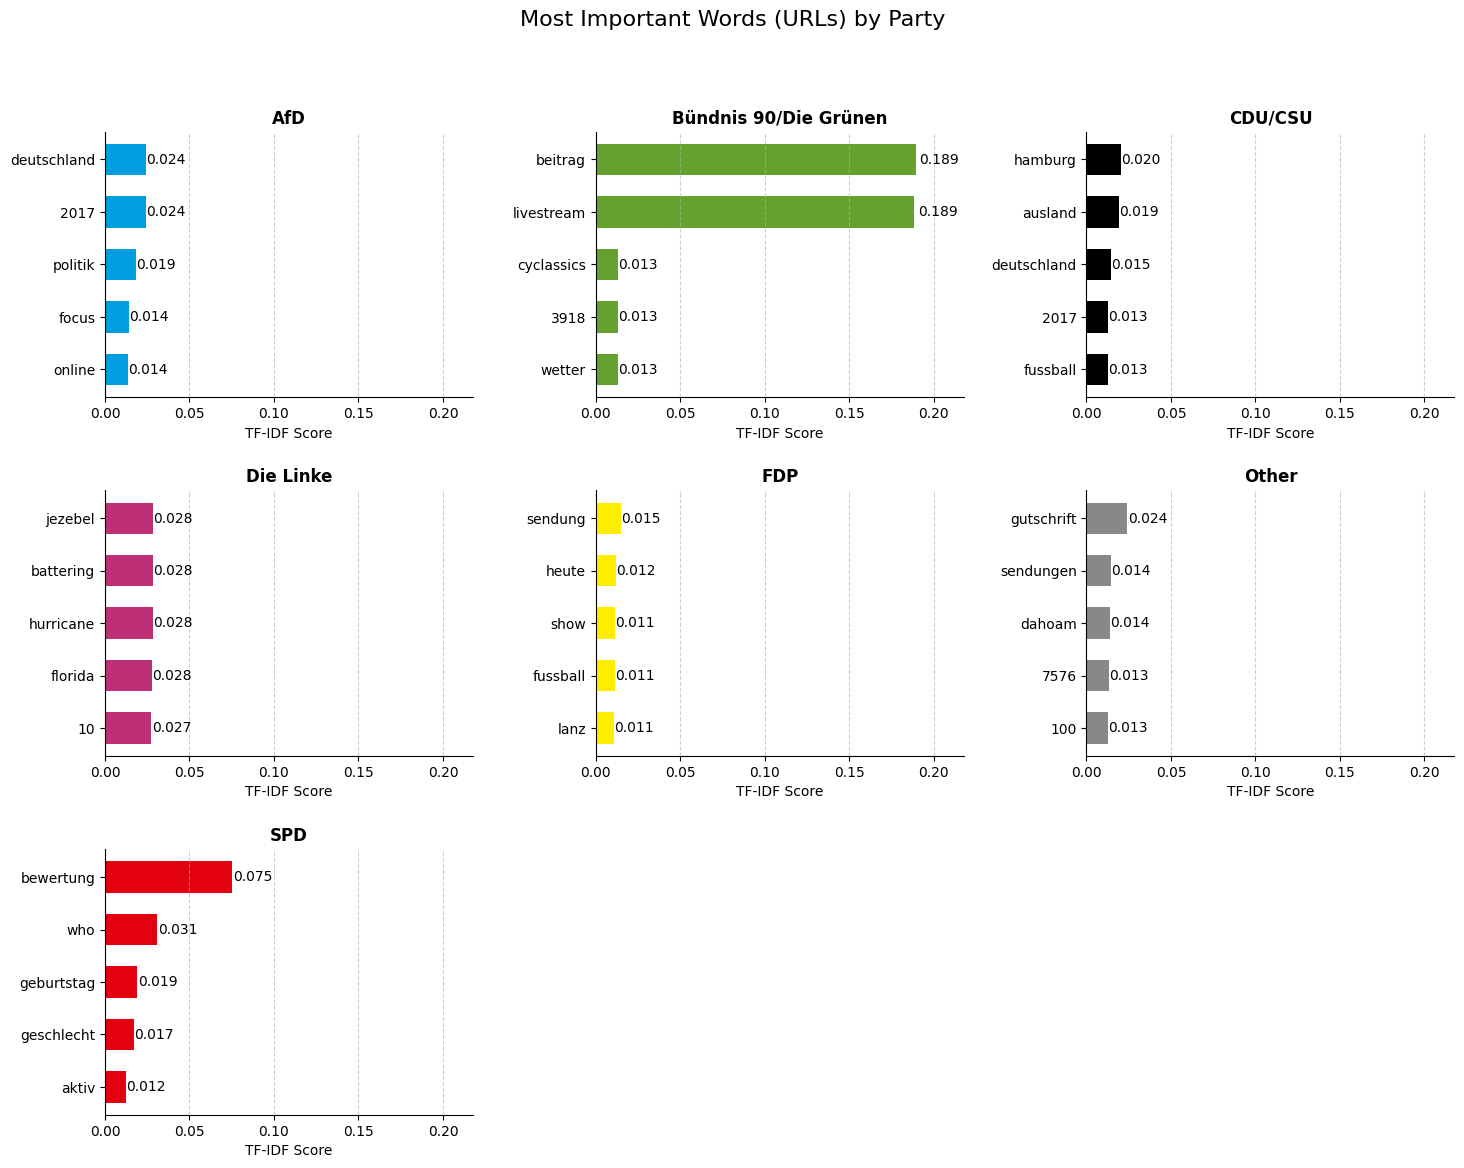

In [14]:
# Create the visualization
fig = plot_top_words_memory_efficient(df, features, tfidf_vectorizer.get_feature_names_out(), ignore_words=[], 
                                      n_terms=5, title="Most Important Words (URLs) by Party")

# Display the plot
plt.show()

## Wide Format Data

In [15]:
dfw = pd.read_csv("Processed_Data/31_merged_wide.csv")

In [16]:
dfw.head()

,personid,duration,text_clean,secondvote,vote_left,vote_green,vote_spd,vote_na_other,vote_fdp,vote_cdu,...,ml_degreestatus,ml_political_interest,adjustedvote,polinterest,adjustedincome,fgender,fvoceduc,frelationship,fmaritalstatus,femployment
0,598642,111731.0,deutschland bka warnt schweren brandstiftungen...,3,0,0,0,0,1,0,...,1,1,1,5,8,männlich,Universit?ts- oder Fachhochschulabschluss,"In einer Beziehung, mit Partner/in zusammenlebend",verheiratet,Erwerbst?tigkeit/Berufst?tigkeit
1,598643,5429.0,lotto samstag 01-07-2017 diese lottozahlen bri...,1,0,0,0,0,0,1,...,0,0,2,3,2,weiblich,Lehre oder vergleichbarer Abschluss,Single/nicht in einer Beziehung,geschieden,"Renten, Pension"
2,599083,1317.0,wdrfernsehen sendung 2017-07-03 boettingers bu...,2,0,0,1,0,0,0,...,0,0,-1,4,5,weiblich,Lehre oder vergleichbarer Abschluss,"In einer Beziehung, mit Partner/in zusammenlebend",geschieden,Erwerbst?tigkeit/Berufst?tigkeit
3,599620,1548.0,landeszeitung geschichte rendsburger stadtmode...,2,0,0,1,0,0,0,...,0,1,-1,4,4,weiblich,Lehre oder vergleichbarer Abschluss,Single/nicht in einer Beziehung,verwitwet,"Renten, Pension"
4,599779,792.0,unterhaltung leute bud spencer gewinnen ausver...,7,0,0,0,1,0,0,...,0,0,0,1,4,weiblich,Lehre oder vergleichbarer Abschluss,"In einer Beziehung, mit Partner/in zusammenlebend",verheiratet,"Renten, Pension"


Taking TF-IDF

In [17]:
dfw['text_clean'] = dfw['text_clean'].fillna('')

# Transform your text data
features_w = tfidf_vectorizer.fit_transform(dfw['text_clean'])

Aggregating by Mean

In [18]:
# Calculate the mean TF-IDF value for each document (row)
wmean_tfidf = features_w.mean(axis=1)

# Convert the sparse matrix result to a regular array
wmean_tfidf_array = wmean_tfidf.A.flatten()

# Add this as a new column to your dataframe
dfw['tf_idf_mean'] = wmean_tfidf_array

In [19]:
dfw[['personid', 'tf_idf_mean']]

,personid,tf_idf_mean
0,598642,0.000751
1,598643,0.000467
2,599083,0.000175
3,599620,0.000229
4,599779,0.000354
...,...,...
1339,41378722,0.000000
1340,41571157,0.000000
1341,41791374,0.000000
1342,41942929,0.000000


Aggregating Advanced

In [20]:
dfw = add_semantic_tfidf_columns(dfw, features_w, tfidf_vectorizer, german_stopwords)

In [21]:
dfw[['personid', 'tf_idf_mean', 'tf_idf_entity_weighted', 'tf_idf_importance_weighted']]

,personid,tf_idf_mean,tf_idf_entity_weighted,tf_idf_importance_weighted
0,598642,0.000751,0.015704,0.015653
1,598643,0.000467,0.030177,0.030251
2,599083,0.000175,0.066274,0.063245
3,599620,0.000229,0.047336,0.047527
4,599779,0.000354,0.084026,0.083554
...,...,...,...,...
1339,41378722,0.000000,0.000000,0.000000
1340,41571157,0.000000,0.000000,0.000000
1341,41791374,0.000000,0.000000,0.000000
1342,41942929,0.000000,0.000000,0.000000


Plotting

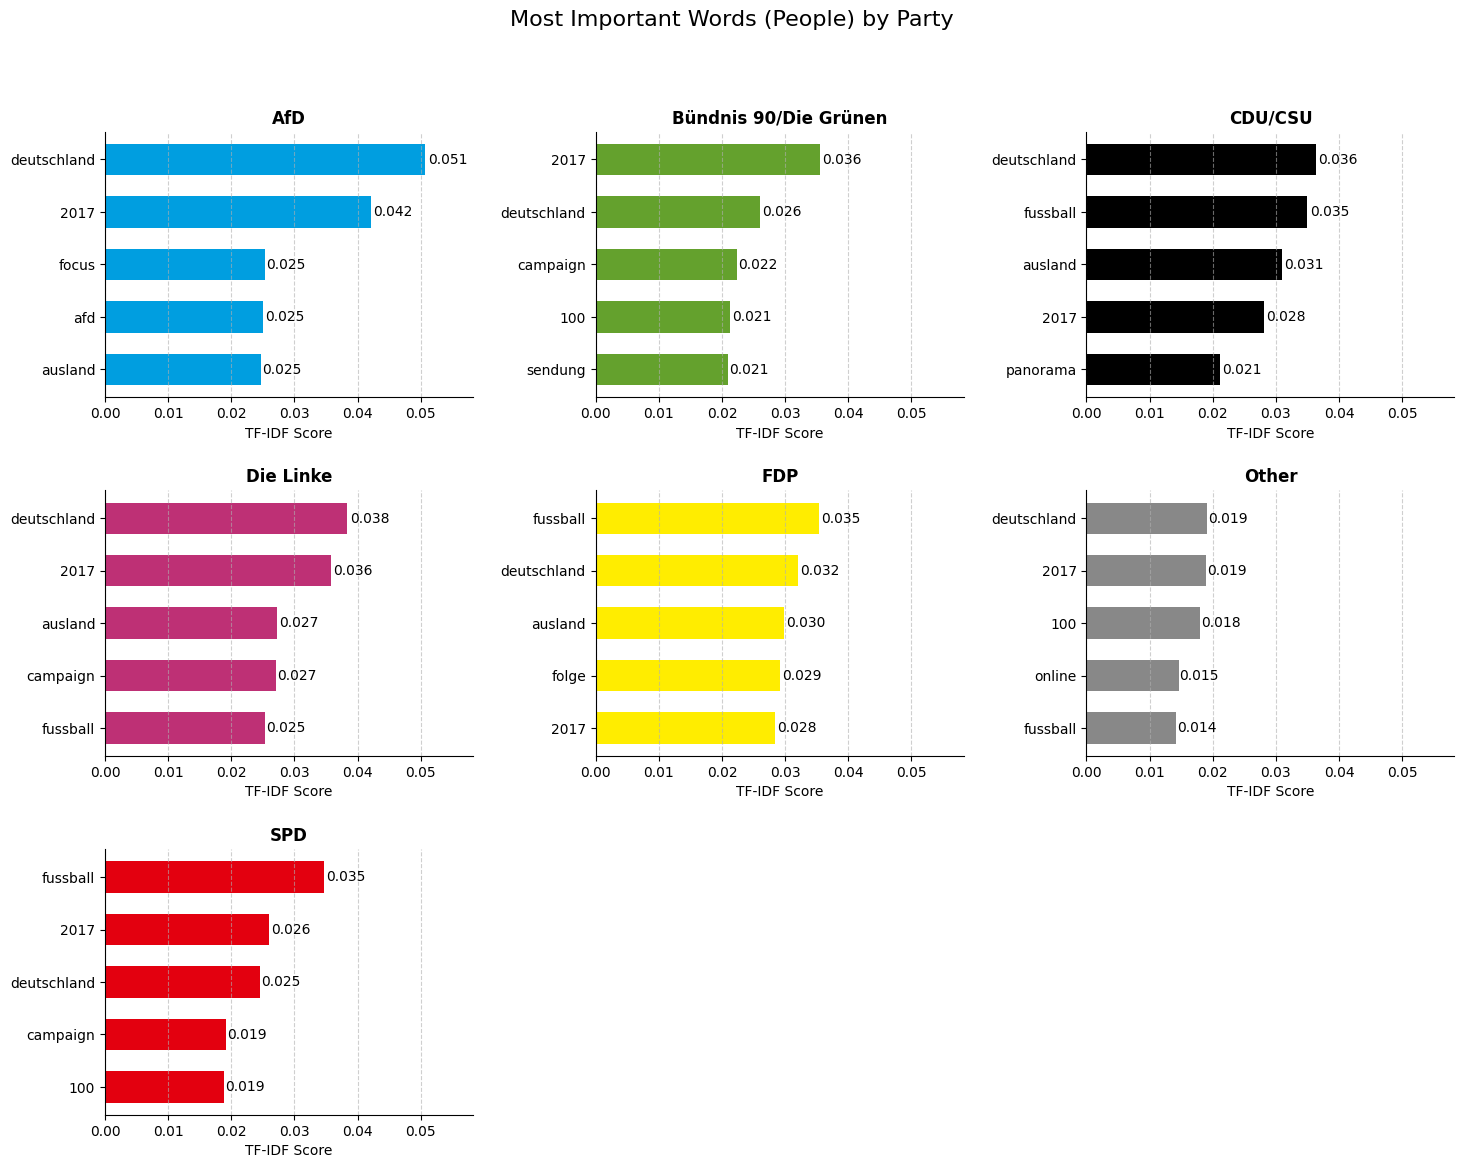

In [22]:
fig = plot_top_words_memory_efficient(dfw, features_w, tfidf_vectorizer.get_feature_names_out(), ignore_words=[],
                                       n_terms=5, title="Most Important Words (People) by Party")

# Display the plot
plt.show()

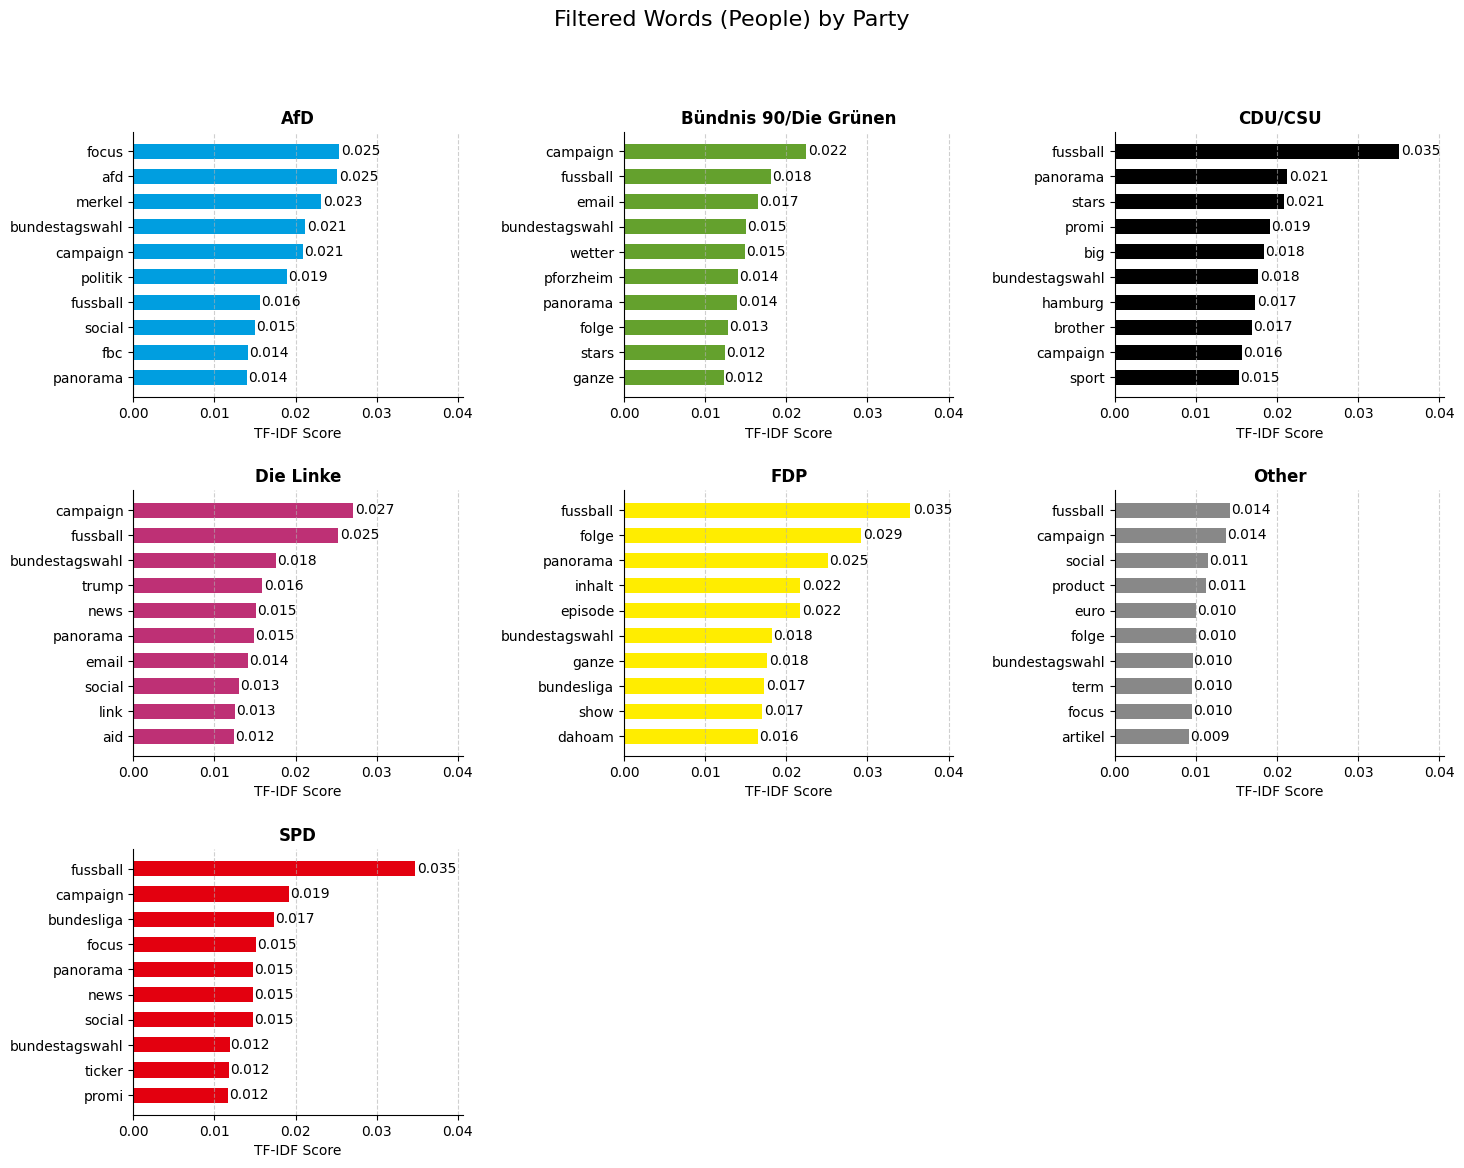

In [23]:
fig = plot_top_words_memory_efficient(dfw, features_w, tfidf_vectorizer.get_feature_names_out(), n_terms=10,
                                      ignore_words = ['facebook', '2017', 'deutschland', 
                                               '100', 'ausland', 'online', 'sendung',
                                               'sendungen', '08', 'medium', '07'],                                                
                                    title='Filtered Words (People) by Party')

# Display the plot
plt.show()

## Write to CSV

In [24]:
df['left_right'] = df['adjustedvote'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))
dfw['left_right'] = dfw['adjustedvote'].apply(lambda x: -1 if x < 0 else (1 if x > 0 else 0))


In [25]:
dfw.left_right.value_counts()

left_right
-1    591
 1    513
 0    240
Name: count, dtype: int64

In [26]:
df.to_csv("Processed_Data/50_textscored_long.csv", index=False)
dfw.to_csv("Processed_Data/51_textscored_wide.csv", index=False)